In [6]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold

In [2]:
# ---- Data ----

if not os.path.exists("train_data"):
    os.mkdir("train_data")
    mnist = fetch_openml("mnist_784", version=1)
    X, y = mnist["data"].values.astype(float).reshape(-1, 28, 28) / 255., mnist["target"].values.astype(int)
    np.savez_compressed("data/mnist.npz", X=X, y=y)

X, Y = np.load("train_data/mnist.npz").values()

X.shape, Y.shape

((70000, 28, 28), (70000,))

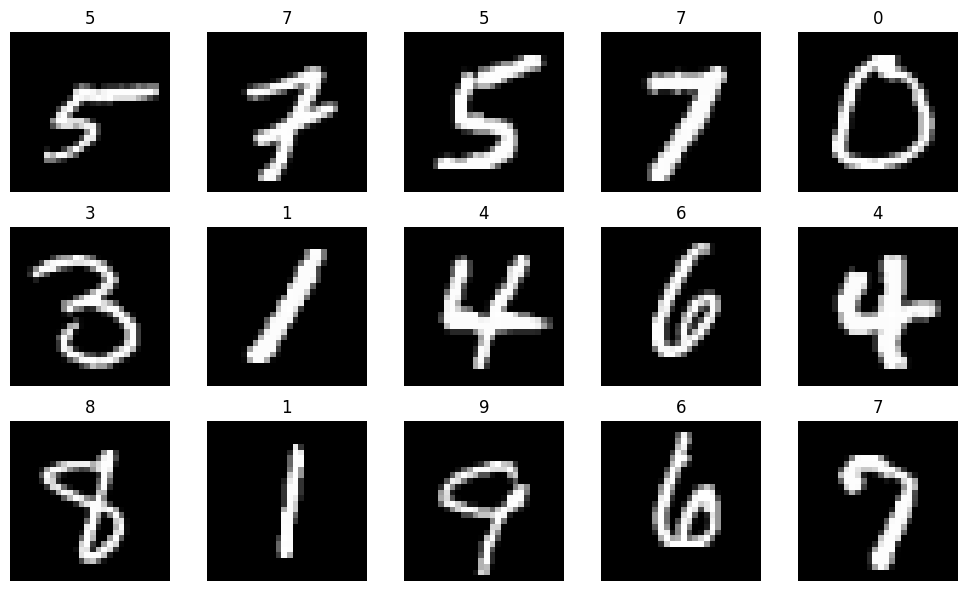

In [3]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        plt.imshow(X[ix], cmap="gray")
        plt.axis("off")
        plt.title(Y[ix])
plt.tight_layout()
plt.show()

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#model_compiled = torch.compile(model)  # optional (new in Pytorch 2.0)
    
model = CNN()
outputs = model(torch.randn(64, 1, 28, 28))
outputs.shape

torch.Size([64, 10])

In [19]:
# ---- Dataset ----

class Dataset(torch.utils.data.Dataset):

    # Constructor
    def __init__(self, X, Y):
        self.X = torch.tensor(X).float()
        self.Y = torch.tensor(Y).long()

    # Number of samples in the dataset
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]
    
    # optional func to genereate every batch
    def collate_fn(self, batch):
        x, y = [], []
        for _x, _y in batch:
            x.append(_x.unsqueeze(0))
            y.append(_y)
        return torch.stack(x), torch.stack(y)  # images are flattened in a single vector    

In [20]:
# ---- Taining ----

dataset = Dataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, collate_fn=dataset.collate_fn)

model = CNN()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epochs = 5
for e in range(1, epochs+1):
    print(f"Epoch {e}/{epochs}")
    for batch_ix, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()           # reset gradients
        outputs = model(x)              # forward pass
        loss = criterion(outputs, y)    # compute loss
        loss.backward()                 # backward pass
        optimizer.step()                # update weights
        if batch_ix % 100 == 0:
            loss, current = loss.item(), (batch_ix + 1) * len(x)
            print(f"loss: {loss:.4f} [{current:>5d}/{len(dataset):>5d}]")

Epoch 1/5
loss: 2.3120 [  100/70000]
loss: 0.3887 [10100/70000]
loss: 0.3559 [20100/70000]
loss: 0.1875 [30100/70000]
loss: 0.1270 [40100/70000]
loss: 0.1120 [50100/70000]
loss: 0.0670 [60100/70000]
Epoch 2/5
loss: 0.1533 [  100/70000]
loss: 0.1385 [10100/70000]
loss: 0.1344 [20100/70000]
loss: 0.1528 [30100/70000]
loss: 0.0775 [40100/70000]
loss: 0.0508 [50100/70000]
loss: 0.0319 [60100/70000]
Epoch 3/5
loss: 0.0776 [  100/70000]
loss: 0.0460 [10100/70000]
loss: 0.1334 [20100/70000]
loss: 0.1112 [30100/70000]
loss: 0.0200 [40100/70000]
loss: 0.0789 [50100/70000]
loss: 0.0398 [60100/70000]
Epoch 4/5
loss: 0.0732 [  100/70000]
loss: 0.0358 [10100/70000]
loss: 0.0519 [20100/70000]
loss: 0.0806 [30100/70000]
loss: 0.0239 [40100/70000]
loss: 0.0285 [50100/70000]
loss: 0.0232 [60100/70000]
Epoch 5/5
loss: 0.0308 [  100/70000]
loss: 0.1317 [10100/70000]
loss: 0.0308 [20100/70000]
loss: 0.1323 [30100/70000]
loss: 0.0628 [40100/70000]
loss: 0.0196 [50100/70000]
loss: 0.0296 [60100/70000]


In [21]:
# ---- Exporting model ----

torch.save(model, "CNN_model.pth")

In [22]:
loaded = torch.load("CNN_model.pth")
loaded

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [23]:
loaded(torch.randn(64, 1, 28, 28))

tensor([[-6.5784e+00, -2.8586e+00,  7.4895e-02, -6.9763e-01, -4.9381e-01,
          9.8676e-01, -7.0054e-02, -2.6618e-01, -1.4250e+00, -5.4984e+00],
        [-2.9363e+00,  2.7166e+00,  4.3399e+00,  2.6253e+00, -5.2474e+00,
         -1.1090e+00, -3.3101e+00, -5.3500e-01, -5.9643e-01, -3.0832e+00],
        [-9.0285e+00, -1.5666e+00, -3.5448e+00, -3.4715e+00,  2.6790e+00,
          1.5627e+00, -6.8260e+00, -5.4332e-03, -6.3237e+00,  1.2853e-01],
        [-6.1517e+00, -7.4054e+00, -1.4951e+00, -1.5462e+00,  8.3580e-01,
          3.6482e+00,  1.2532e+00, -8.8389e+00, -1.2990e+00,  1.1521e+00],
        [-4.8158e+00, -3.9473e+00, -4.5817e+00,  8.4836e-01, -6.6169e+00,
          5.0942e+00, -8.6024e+00, -7.3478e+00,  9.0835e-01,  1.3359e+00],
        [-8.7107e+00, -5.4422e+00, -7.4340e+00, -8.7226e+00,  1.2059e+00,
          9.2284e+00,  5.6247e+00, -1.4987e+01,  7.4871e-02, -1.4538e+00],
        [-3.9232e+00, -2.7586e-01,  9.2945e+00,  1.0501e+00, -7.4826e+00,
         -3.2599e+00, -6.3194e+0